In [ ]:
from prettytable import PrettyTable
from IPython.display import display, HTML
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

print("""
         / \__
        (    @\___
        /         O  <Hello!>
       /   (_____/
      /_____/   U""")


         / \__
        (    @\___
        /         O  <Hello!>
       /   (_____/
      /_____/   U


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


>## ***Define Linear Layer***  


>**Variables:** 

*   `in_features = number of dimension, vector(x) ` 
*   `out_featues = output of this layer, vector(y), equal number of neurals in the layer.`
*  `layer_name - could be 'hidden' or 'output'.`
*  `biasV - if there is bias we will add vector(b)`  
* `device=  the desired device of returned tensor (CPU/CUDA)`
*   `dtype = data type of returned tensor.`

>**Layer equation:**   
As the name implies, the layer performs a linear equation:  
![picture](https://drive.google.com/uc?export=view&id=15pfqqQ0was1s7Ubzn-Gp5C2fS6CkzoFo)  
note: here `vector(z)` = output of the layer, and `vector(y)` is the output of the network.  


 
 



In [ ]:
torch.manual_seed(0)
class Linear(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int,layer_name:str, biasV: bool = True, device=None, dtype=None) -> None:
      kwargs = {'device': device, 'dtype': dtype} #device=  the desired device of returned tensor (CPU/CUDA), dtype = data type of returned tensor. 
      super(Linear, self).__init__()
      self.in_features = in_features
      self.out_features = out_features
      self.layer_name = layer_name
      #creat an empty tensor input_dimXoutput_dim for vector(w)
      self.weight = nn.Parameter(torch.empty((in_features, out_features), **kwargs))
      #create an empty tensor 1Xoutput_dim for vector(b)
      if biasV: 
        self.bias = nn.Parameter(torch.empty(out_features, **kwargs))
      else:
        self.register_parameter('bias', None)
      self.reset_parameters()

    #Initializes vector(w),vector(b) randomly
    def reset_parameters(self) -> None:
      self.weight = nn.Parameter(torch.rand([self.out_features, self.in_features]))
      if self.bias is not None:
        self.bias = nn.Parameter(torch.rand([self.out_features]))
        
    #Initializes vector(w),vector(b) manually
    def set_weights(self, w, b):
      #TODO: validate size of empty tensor befor initialize it
      checkInput(self.weight.size(),w.size(),"==",True,"Error initializing vector w")
      checkInput(self.bias.size(),b.size(),"==",True,"Error initializing vector b")
      self.weight = nn.Parameter(torch.tensor(w))
      if self.bias is not None:
        self.bias = nn.Parameter(torch.tensor(b))
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
      self.vector_x = input
      self.vector_z = torch.matmul(input, torch.transpose(self.weight,0,1)) + self.bias
      return self.vector_z

    def extra_repr(self) -> str:
      return 'in_features={}, out_features={}, bias={}'.format(
          self.in_features, self.out_features, self.bias is not None
        )
    def pretty_repr(self):
      t = PrettyTable(['Layer name','#in dim','#out dim', 'Vector(w)', 'Vector(x)', 'Vector(b)', 'Vector(z)']) 
   
      t.add_row([self.layer_name, self.in_features, self.out_features ,self.weight.detach().numpy(), self.vector_x.detach().numpy(), self.bias.detach().numpy() ,self.vector_z.detach().numpy()])
      return t


 ># ***Define BTU Layer***  
 

>**Variables:** 

*   ` T - temperature, as much close to 0 BTU graph look like the sigmoid` 
>**Layer equation:**   
   
   ![picture](https://drive.google.com//uc?export=view&id=1_7pPkpv7IKytDhQEf0FYCFFHHKYguo-F)   
note: here `vector(z)` = output of the layer, and `vector(y)` is the output of the network.  
![picture](https://drive.google.com//uc?export=view&id=11JmF2c4h-R7rdHcjB-cgjPt435qWH390)  

In [ ]:
class BTU(torch.nn.Module):
  def __init__(self, T=1, inplace: bool = False):
      super(BTU, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

#Define XOR Model:  


In [ ]:
out_dim = 1
class XOR_Net_Model(nn.Module):
  def __init__(self,dim, num_hidden,bypass=True):
    super().__init__()
    self.dim = dim
    self.num_hidden = num_hidden
    self.bypass = bypass

    self.hidden = Linear(dim, num_hidden,"Hidden Layer")
    if self.bypass:
      self.output = Linear(num_hidden + dim, out_dim,"Output Layer")
    else:
      self.output = Linear(num_hidden, out_dim,"Outpput Layer")
    self.BTU = BTU(0.5)

  def reset_parameters(self,model):
    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


  def forward(self, input):
    self.input = input
    z1 = self.hidden(input)
    y1 = self.BTU(z1)
    if self.bypass:
      y1_concat = torch.cat((input, y1), 1)
      z2 = self.output(y1_concat)
    else:
      z2 = self.output(y1)
    self.final_output = self.BTU(z2)
    return self.BTU(z2)
  
  def print_network(self)->None:
    print('Network input:\n{}\nNetwork output:\n{}\n '.format(self.input,self.final_output))
    #print hidden layer
    print(self.hidden.pretty_repr())
    print()
    #print output layer
    print(self.output.pretty_repr())


# Define Loss  
loss = CE (cross- entropy), equation:  
![picture](https://drive.google.com//uc?export=view&id=1uxoEvwS00EBWOhHgK2KXrBud_h2r2lHL)    


In [ ]:
def Loss(out, t_train):
  return -(1/t_train.shape[0])*torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))  # Cross Entropy loss function


# Define Train process :  
## pytorch - connection between loss.backward() and optimizer.step()  
[Explain the connection loss&optimizer](https://newbedev.com/pytorch-connection-between-loss-backward-and-optimizer-step)

In [ ]:
size_train = 4
def train(model, x, t, optimizer,split_loss = 0):
  y_pred = model(x) #output of the hypothesis
  
  loss = Loss(y_pred, t)

  # zero gradients berfore running the backward pass
  optimizer.zero_grad()

  # backward pass to compute the gradient of loss
  # backprop + accumulate 
  loss.backward()

  # update params
  optimizer.step()
  
  if(split_loss):
    y_pred_cp = y_pred.clone()
    y_pred_cp = y_pred_cp[0:size_train:1]
    t_cp = t.clone()
    t_cp = t_cp[0:size_train:1]
    loss_train = Loss(y_pred_cp, t_cp)
    return (loss,loss_train)
    
  return loss

# Feed-Forward Neural Network:  
![picture](https://drive.google.com//uc?export=view&id=1qdi-jLDXkFQwu4TAHDEnHsJJ4yG0tkKd)

In [ ]:
def trainning(model,x,t,optimizer):
  num_epocs = 40001
  success = False
  limit_delta = 0.0001
  counter_good_loss = 0 
  delta_loss = 0
  total_epocs = 0
  current_loss =  train(model, x, t, optimizer)

  for i in range(num_epocs):
    if(i >=num_epocs):
      success = False
      break
    loss,loss_train = train(model, x, t, optimizer,split_loss=1)
    delta_loss = abs(current_loss - loss)
    if ((delta_loss <= limit_delta) and loss < 0.2):
      counter_good_loss+=1
    else:
      counter_good_loss = 0
    if (counter_good_loss >=10):
      success = True
      break
    current_loss = loss

  res = [i,loss.detach().numpy(),loss_train.detach().numpy(),success]
  if model.num_hidden == 1:
    print(model.hidden.pretty_repr())

  return res
  

In [ ]:
class experiment():
  def __init__(self,id,num_hidden,bypass,x_valid,t_valid,input_dim = 2,learning_rate=0.2):
    self.id = id
    self.num_hidden = num_hidden
    self.bypass = bypass
    self.learning_rate = learning_rate
    #Each failed run raises the total fail by 1
    self.total_fail =0
    data1 = {'#Experiment':  [],'mean(#epochs)': [],'sd(#epochs)':[],'mean(train loss)':[],'sd(train loss)':[],'mean(valid loss)':[],'sd(valid loss)':[],'#fails':[]}
    data2 =  {'#epochs':  [],'loss (Validation)': [],'loss (train)':[]}
    self.summary_table = pd.DataFrame(data1)
    self.data_table = pd.DataFrame(data2)
    self.model = XOR_Net_Model(input_dim,num_hidden,bypass=bypass)
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
    self.x_valid = x_valid
    self.t_valid = t_valid

  def activate(self):
    self.Experimenting()
    self.set_summary_table()
  
  def Experimenting(self):
    #Each experiment should run a total of 10 successful runs
    total_try = 10
    #counter xucceed: Will indicate a number of successful "runs"
    counter_succeed = 0
    #copy to calc train loss 
    x_val_cp = self.x_valid.clone()

    while(counter_succeed < total_try):
      res = trainning(self.model,x_val_cp,self.t_valid,self.optimizer)
      #res[3]: A Boolean value that indicates a successful run
      if(res[3]):
        counter_succeed+=1 #good run
        #The table holds the experiment information held in the res array
        self.data_table = self.add_row_table(self.data_table,res[:3])
      else:
        self.total_fail+=1

      #After each run - the weights of the neural network should be restarted
      self.model.reset_parameters(self.model)
      #After updating the model, the optimizer must be updated with the new values, so the new parameters are added to its states dictionary.
      self.optimizer.add_param_group({'params':self.model.parameters()})

  def set_summary_table(self):
    cols_mean = self.data_table[["#epochs","loss (train)","loss (Validation)"]].mean()
    cols_sd =  self.data_table[["#epochs","loss (train)","loss (Validation)"]].std()
    row = [self.id,cols_mean[0],cols_sd[0],cols_mean[1],cols_sd[1],cols_mean[2],cols_sd[2],self.total_fail]
    self.summary_table = self.add_row_table(self.summary_table,row)

  def add_row_table(self,table,row):
    cols = table.columns
    data = dict()
    for i in range(len(row)):
      data[cols[i]] = row[i]
    table = table.append(data,ignore_index=True,sort=False)
    return table

  def print_experiment(self):
    print(f'Experiment #{self.id}:\nNumber of hidden neurals = {self.num_hidden}\tBypass = {self.bypass}\tlearning rate = {self.learning_rate}')
    display(self.data_table)
    display(self.summary_table)


## For each experiment we will save the following tables:  

In [ ]:
data_table = PrettyTable(['#epochs','loss (Validatin)','loss (train)']) 
print(data_table)


+---------+------------------+--------------+
| #epochs | loss (Validatin) | loss (train) |
+---------+------------------+--------------+
+---------+------------------+--------------+


In [ ]:
summary = PrettyTable(['#Experiment','mean(#epochs)','sd(#epochs)','mean(train loss)','sd(train loss)','mean(valid loss)','sd(valid loss)','#fails']) 
print(summary)    


+-------------+---------------+-------------+------------------+----------------+------------------+----------------+--------+
| #Experiment | mean(#epochs) | sd(#epochs) | mean(train loss) | sd(train loss) | mean(valid loss) | sd(valid loss) | #fails |
+-------------+---------------+-------------+------------------+----------------+------------------+----------------+--------+
+-------------+---------------+-------------+------------------+----------------+------------------+----------------+--------+


### define validation group.
note: When calculating the loss for validation - a split is performed (because it contains the training group) to calculate the loss of the training.

In [ ]:
# x_train = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], requires_grad=True, dtype=torch.float32)
# t_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

x_valid = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1],[1,0.1],[1,0.9],[0.9,0.9],[0.1,0.9]], requires_grad=True, dtype=torch.float32)
t_valid = torch.tensor([[0], [1], [1], [0],[1],[0],[0],[1]], dtype=torch.float32)


># Let's start:  






>## Experiment number 1:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.1
  *   Number of neurons in the hidden layer = 2  
  *   Bypass = False

In [ ]:
num_hidden = 2
input_dim = 2
learning_rate = 0.1

exp1 = experiment(1,num_hidden,False,x_valid,t_valid,learning_rate=0.1)
exp1.activate()
exp1.print_experiment()

Experiment #1:
Number of hidden neurals = 2	Bypass = False	learning rate = 0.1


,#epochs,loss (Validation),loss (train)
0,1972.0,0.05263438,0.06766455
1,1639.0,0.054318238,0.0637329
2,2624.0,0.050747354,0.0685065
3,1442.0,0.054366626,0.062158346
4,1524.0,0.053419672,0.057462484
5,1959.0,0.053405803,0.056159854
6,3589.0,0.049942132,0.046609215
7,1337.0,0.05434916,0.062316637
8,1306.0,0.054267127,0.06178868
9,2441.0,0.051405825,0.0684724


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,1.0,1983.3,722.489531,0.061487,0.006737,0.052886,0.001645,5.0


>## Experiment number 2:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.1
  *   Number of neurons in the hidden layer = 2  
  *   Bypass = True

In [ ]:
num_hidden = 2
input_dim = 2
learning_rate = 0.1

exp2 = experiment(2,num_hidden,True,x_valid,t_valid,learning_rate=0.1)
exp2.activate()
exp2.print_experiment()


Experiment #2:
Number of hidden neurals = 2	Bypass = True	learning rate = 0.1


,#epochs,loss (Validation),loss (train)
0,1270.0,0.09105918,0.080463156
1,1384.0,0.066070504,0.05447952
2,2434.0,0.09488049,0.084879644
3,1404.0,0.08803219,0.0767803
4,1233.0,0.07430051,0.06230154
5,1364.0,0.09118145,0.08015682
6,1339.0,0.091910124,0.08055687
7,1526.0,0.084180966,0.07212111
8,1304.0,0.08068911,0.06895785
9,1315.0,0.081803754,0.07035803


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,2.0,1457.3,352.564903,0.073105,0.009433,0.084411,0.008996,0.0


>## Experiment number 3:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.1
  *   Number of neurons in the hidden layer = 4 
  *   Bypass = False

In [ ]:
num_hidden = 4
input_dim = 2
learning_rate = 0.1

exp3 = experiment(3,num_hidden,False,x_valid,t_valid,learning_rate=0.1)
exp3.activate()
exp3.print_experiment()


Experiment #3:
Number of hidden neurals = 4	Bypass = False	learning rate = 0.1


,#epochs,loss (Validation),loss (train)
0,1386.0,0.05167248,0.052943014
1,1308.0,0.05554059,0.045221124
2,1729.0,0.05238901,0.05884597
3,1527.0,0.05568663,0.048425175
4,1856.0,0.05846904,0.048729267
5,1487.0,0.057396717,0.04977638
6,1680.0,0.06327185,0.070454
7,1147.0,0.05311762,0.057413787
8,4361.0,0.05356832,0.04520631
9,1302.0,0.049149975,0.03820796


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,3.0,1778.3,933.152369,0.051522,0.008982,0.055026,0.004009,0.0


>## Experiment number 4:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.1
  *   Number of neurons in the hidden layer = 4 
  *   Bypass = True

In [ ]:
num_hidden = 4
input_dim = 2
learning_rate = 0.1

exp4 = experiment(4,num_hidden,True,x_valid,t_valid,learning_rate=0.1)
exp4.activate()
exp4.print_experiment()



Experiment #4:
Number of hidden neurals = 4	Bypass = True	learning rate = 0.1


,#epochs,loss (Validation),loss (train)
0,1119.0,0.06683402,0.055262223
1,1249.0,0.06704007,0.05372695
2,1266.0,0.06535087,0.05171942
3,1373.0,0.09068373,0.07868158
4,1296.0,0.09154359,0.080347165
5,1194.0,0.06548751,0.053302485
6,1469.0,0.093733974,0.0828109
7,1657.0,0.09282893,0.08265999
8,1552.0,0.062122993,0.050407916
9,1362.0,0.05958707,0.046221405


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,4.0,1353.7,165.87147,0.063514,0.015385,0.075521,0.01454,0.0


>## Experiment number 5:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.01
  *   Number of neurons in the hidden layer = 2
  *   Bypass = False

In [ ]:
num_hidden = 2
input_dim = 2
learning_rate = 0.01

exp5 = experiment(5,num_hidden,False,x_valid,t_valid,learning_rate = 0.01)
exp5.activate()
exp5.print_experiment()



Experiment #5:
Number of hidden neurals = 2	Bypass = False	learning rate = 0.01


,#epochs,loss (Validation),loss (train)
0,10457.0,0.19928797,0.26811308
1,11609.0,0.19933845,0.26174214
2,9356.0,0.19918883,0.20924576
3,9251.0,0.19944583,0.19975716
4,12958.0,0.19924182,0.25690523
5,10319.0,0.19914946,0.20810196
6,11009.0,0.1992333,0.24267519
7,13539.0,0.1994539,0.20037605
8,14657.0,0.19916347,0.19977441
9,9692.0,0.1992733,0.25807893


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,5.0,11284.7,1869.211542,0.230477,0.029339,0.199278,0.000107,12.0


>## Experiment number 6:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.01
  *   Number of neurons in the hidden layer = 2
  *   Bypass =  True

In [ ]:
num_hidden = 2
input_dim = 2
learning_rate = 0.01

exp6 = experiment(6,num_hidden,True,x_valid,t_valid,learning_rate = 0.01)
exp6.activate()
exp6.print_experiment()

Experiment #6:
Number of hidden neurals = 2	Bypass = True	learning rate = 0.01


,#epochs,loss (Validation),loss (train)
0,7479.0,0.19952731,0.19222386
1,23911.0,0.1994917,0.18744598
2,8817.0,0.19956948,0.1933888
3,7067.0,0.19962767,0.19604298
4,7440.0,0.19960713,0.1958009
5,7518.0,0.19939116,0.1894746
6,8922.0,0.19956982,0.19388118
7,8397.0,0.19947653,0.18718779
8,7443.0,0.19939455,0.18615063
9,10324.0,0.19963029,0.19235787


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,6.0,9731.8,5079.838904,0.191395,0.00361,0.199529,0.000089,0.0


>## Experiment number 7:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.01
  *   Number of neurons in the hidden layer = 4
  *   Bypass =  False

In [ ]:
num_hidden = 4
input_dim = 2
learning_rate = 0.01

exp7 = experiment(7,num_hidden,False,x_valid,t_valid,learning_rate = 0.01)
exp7.activate()
exp7.print_experiment()



Experiment #7:
Number of hidden neurals = 4	Bypass = False	learning rate = 0.01


,#epochs,loss (Validation),loss (train)
0,7450.0,0.1992138,0.17666197
1,8456.0,0.199215,0.17959322
2,8658.0,0.19917274,0.17689054
3,8300.0,0.19917294,0.175449
4,7128.0,0.19922358,0.21197282
5,8684.0,0.19924182,0.17805445
6,7197.0,0.1992245,0.17498854
7,8027.0,0.19908606,0.21602584
8,9243.0,0.19921792,0.2415969
9,9306.0,0.19929498,0.19965015


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,7.0,8244.9,785.854305,0.193088,0.023233,0.199206,0.000054,0.0


>## Experiment number 8:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.01
  *   Number of neurons in the hidden layer = 4
  *   Bypass =  True

In [ ]:
num_hidden = 4
input_dim = 2
learning_rate = 0.01

exp8 = experiment(8,num_hidden,True,x_valid,t_valid,learning_rate = 0.01)
exp8.activate()
exp8.print_experiment()



Experiment #8:
Number of hidden neurals = 4	Bypass = True	learning rate = 0.01


,#epochs,loss (Validation),loss (train)
0,9940.0,0.19957152,0.19249201
1,6321.0,0.19959739,0.19175534
2,7947.0,0.19958891,0.1927345
3,8033.0,0.19952479,0.19081141
4,6260.0,0.19953202,0.18707706
5,6559.0,0.19944577,0.18582007
6,7667.0,0.19960345,0.18967015
7,7910.0,0.19946127,0.18557858
8,10235.0,0.19963571,0.19140932
9,5828.0,0.19941485,0.18716758


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,8.0,7670.0,1506.777946,0.189452,0.002791,0.199538,0.000075,0.0


>## Experiment number 9:  


>*   parameters:  
  *   Learning rate (aka. Lamda) = 0.2
  *   Number of neurons in the hidden layer = 1
  *   Bypass =  True

In [ ]:
num_hidden = 1
input_dim = 2
learning_rate = 0.2

exp9 = experiment(9,num_hidden,True,x_valid,t_valid,learning_rate = 0.2)
exp9.activate()
exp9.print_experiment()

+--------------+---------+----------+-------------------------+-------------+--------------+----------------+
|  Layer name  | #in dim | #out dim |        Vector(w)        |  Vector(x)  |  Vector(b)   |   Vector(z)    |
+--------------+---------+----------+-------------------------+-------------+--------------+----------------+
| Hidden Layer |    2    |    1     | [[3.5905318 3.7107244]] |  [[0.  0. ] | [-1.5345471] | [[-1.5340666]  |
|              |         |          |                         |   [0.  1. ] |              |  [ 2.1756954]  |
|              |         |          |                         |   [1.  0. ] |              |  [ 2.055573 ]  |
|              |         |          |                         |   [1.  1. ] |              |  [ 5.7653346]  |
|              |         |          |                         |   [1.  0.1] |              |  [ 2.4265494]  |
|              |         |          |                         |   [1.  0.9] |              |  [ 5.3943586]  |
|         

,#epochs,loss (Validation),loss (train)
0,937.0,0.06593154,0.05714868
1,999.0,0.06596314,0.057176344
2,909.0,0.06597725,0.0571855
3,1053.0,0.065900385,0.05710886
4,900.0,0.06594525,0.057167005
5,1069.0,0.06593917,0.057149526
6,871.0,0.06590196,0.057099037
7,946.0,0.06589731,0.057070106
8,1049.0,0.06592989,0.057148203
9,1805.0,0.065868616,0.0570739


,#Experiment,mean(#epochs),sd(#epochs),mean(train loss),sd(train loss),mean(valid loss),sd(valid loss),#fails
0,9.0,1053.8,273.020064,0.057133,0.000042,0.065925,0.000033,0.0


<img src="https://drive.google.com//uc?export=view&id=1XHQgtG3Fm7Y6pT6T227TvFTBiZJinIy4" align = "right">






>## First running results:   
note: In zoom-in you can probably see something   
<img src="https://drive.google.com//uc?export=view&id=18PGbs9vH0hOxvuPT5bns4DwjQXOSsVfo" align = "right">  


In [ ]:
exp9.model.print_network()

Network input:
tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 1.0000],
        [1.0000, 0.1000],
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]], grad_fn=<CloneBackward0>)
Network output:
tensor([[0.0857],
        [0.9383],
        [0.9538],
        [0.0273],
        [0.9208],
        [0.0525],
        [0.0955],
        [0.9400]], grad_fn=<MulBackward0>)
 
+--------------+---------+----------+---------------------------+-------------+--------------+----------------+
|  Layer name  | #in dim | #out dim |         Vector(w)         |  Vector(x)  |  Vector(b)   |   Vector(z)    |
+--------------+---------+----------+---------------------------+-------------+--------------+----------------+
| Hidden Layer |    2    |    1     | [[0.03153878 0.37630665]] |  [[0.  0. ] | [0.39830786] | [[-1.5288634]  |
|              |         |          |                           |   [0.  1. ] |              |  [ 2.1733406]  |
|  

# Experiment 9-   
* **The neuron in the hidden layer behaves like an *OR* function.**  
  **If we pay attention, the neuron output is negative throughout the  epochs only when the input is x1 = 0, x2 = 0**

# Evaluating the results:

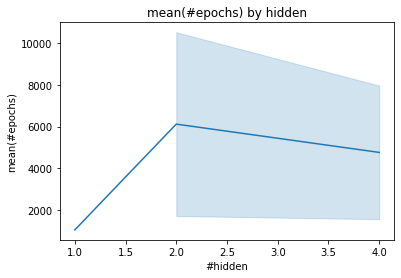

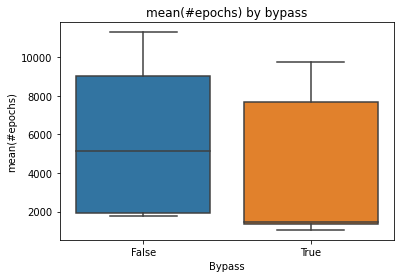

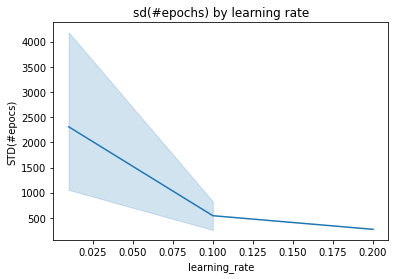

In [ ]:
# print(exp1.summary_table.iloc[0]['mean(#epochs)'])
total_data = {'#hidden':  [exp1.num_hidden, exp2.num_hidden,exp3.num_hidden,exp4.num_hidden,exp5.num_hidden 
                                 ,exp6.num_hidden,exp7.num_hidden,exp8.num_hidden,exp9.num_hidden],
                     'mean(#epochs)': [exp1.summary_table.iloc[0]['mean(#epochs)'],exp2.summary_table.iloc[0]['mean(#epochs)'],
                                       exp3.summary_table.iloc[0]['mean(#epochs)'],exp4.summary_table.iloc[0]['mean(#epochs)'],
                                       exp5.summary_table.iloc[0]['mean(#epochs)'],exp6.summary_table.iloc[0]['mean(#epochs)'],
                                       exp7.summary_table.iloc[0]['mean(#epochs)'],exp8.summary_table.iloc[0]['mean(#epochs)'],
                                       exp9.summary_table.iloc[0]['mean(#epochs)']], 
                     'Bypass':[exp1.bypass, exp2.bypass,exp3.bypass,exp4.bypass,exp5.bypass,exp6.bypass,exp7.bypass,exp8.bypass,exp9.bypass],
                    'learning_rate':[exp1.learning_rate, exp2.learning_rate,exp3.learning_rate,exp4.learning_rate,exp5.learning_rate,
                                     exp6.learning_rate,exp7.learning_rate,exp8.learning_rate,exp9.learning_rate],
              'STD(#epocs)':[exp1.summary_table.iloc[0]['sd(#epochs)'],exp2.summary_table.iloc[0]['sd(#epochs)'],
                                       exp3.summary_table.iloc[0]['sd(#epochs)'],exp4.summary_table.iloc[0]['sd(#epochs)'],
                                       exp5.summary_table.iloc[0]['sd(#epochs)'],exp6.summary_table.iloc[0]['sd(#epochs)'],
                                       exp7.summary_table.iloc[0]['sd(#epochs)'],exp8.summary_table.iloc[0]['sd(#epochs)'],
                                       exp9.summary_table.iloc[0]['sd(#epochs)']]}
df_res = pd.DataFrame(total_data)
#1. mean(epoc) x number_hidden
sns.lineplot(data = df_res, x="#hidden", y = 'mean(#epochs)').set(title = 'mean(#epochs) by hidden')
plt.show()
print("\n")

#2.mean(epoc) x Bypass
sns.boxplot(data=df_res, x='Bypass', y='mean(#epochs)').set(title = 'mean(#epochs) by bypass')
plt.show()
print("\n")

#3.STD X learning rate
sns.lineplot(data = df_res, x="learning_rate", y = 'STD(#epocs)').set(title = 'sd(#epochs) by learning rate')
plt.show()
print("\n")

z=[-1.5288634  2.1733406  2.0505798  5.752784   2.4208002  5.382563
  5.0246186  2.1610644]
x1 =[0.  0.  1.  1.  1.  1.  0.9 0.1]
x2 =[0.  1.  0.  1.  0.1 0.9 0.9 0.9]

Neuron behavior from experiment 9 in space:



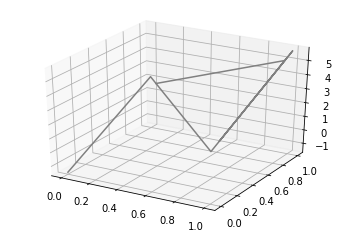

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
x1 = exp9.model.hidden.vector_x[:, 0].detach().numpy()
x2 = exp9.model.hidden.vector_x[:, 1].detach().numpy()
z = exp9.model.hidden.vector_z[:, 0].detach().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
print(f'z={z}\nx1 ={x1}\nx2 ={x2}\n\nNeuron behavior from experiment 9 in space:\n')
ax.plot3D(x1, x2, z, 'gray')


# Analysis of Results  


1.   mean epoch by hidden:  
It can be seen that starting from a layer with 2 hidden neurons we begin to decrease the mean epochs.
Also a hidden layer with a single neuron is unusual and significantly lower than the rest.
- The more neurons there are in the hidden layer, the lower the average restraint (Except for one hidden).
2.    mean epoch by Bypass:  
It can be seen that when there is a bypass there is a significant decrease in the average epochs.

3. sd epochs by learning rate:  
It can be seen that as the rate of learning increases the standard deviation decreases significantly and vice versa, as the rate of learning decreases the standard deviation increases significantly.
This makes sense because the pace of learning affects the epoch number.



In [ ]:
print("""
         / \__
        (    @\___
        /         O  <The end!>
       /   (_____/
      /_____/   U""")


         / \__
        (    @\___
        /         O  <The end!>
       /   (_____/
      /_____/   U


#Conclusions from the assignment  


1.   If the weights are changed in the middle of the training, the optimizer must be updated, since if this is not done, no training will be performed for the neural network.  

2.   reminder: standard deviation calculation <img src="https://drive.google.com//uc?export=view&id=1grv7lkY4fiwyiqVWR23dKu5ORTAHMxsF" align = "right">  

3.   [to resize image](https://resizeimage.net/)
4.   When dividing the loss by the number of examples, convergence takes place more quickly because this reduces the error.





